# Source:
The whole notebook is based on awjuliani's work. I recommend to check it out.

* blog: https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-2-ded33892c724
* code: https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb

In [32]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gym

try:
    xrange = xrange
except:
    xrange = range

env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
gamma = 0.99

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    discounted_r = discounted_r - np.mean(discounted_r)
    return discounted_r

In [3]:
class agent():
    def __init__(self, lr, s_size,a_size,h_size):
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        self.state_in= tf.placeholder(shape=[None,s_size],dtype=tf.float32)
        hidden = slim.fully_connected(self.state_in,h_size,biases_initializer=None,activation_fn=tf.nn.relu)
        self.output = slim.fully_connected(hidden,a_size,activation_fn=tf.nn.softmax,biases_initializer=None)
        self.chosen_action = tf.argmax(self.output,1)

        #The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        #to compute the loss, and use it to update the network.
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))

In [4]:
tf.reset_default_graph() #Clear the Tensorflow graph.

myAgent = agent(lr=1e-2,s_size=4,a_size=2,h_size=8) #Load the agent.

total_episodes = 10000 #Set total number of episodes to train agent on.
max_ep = 499
update_frequency = 100
show_results = 100

init = tf.global_variables_initializer()
game_lengths = []

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 0
    total_reward = []
    total_lenght = []
        
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
        
    while i <= total_episodes:
        s = env.reset()
        running_reward = 0
        ep_history = []
        for j in range(max_ep):
            #Probabilistically pick an action given our network outputs.
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:[s]})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)

            s1,r,d,_ = env.step(a) #Get our reward for taking an action given a bandit.
            ep_history.append([s,a,r,s1])
            s = s1
            running_reward += r
            
            if d == True:
                #Update the network.
                ep_history = np.array(ep_history)
                ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict = {myAgent.reward_holder:ep_history[:,2],
                             myAgent.action_holder:ep_history[:,1],
                             myAgent.state_in:np.vstack(ep_history[:,0])
                            }
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if i % update_frequency == 0 and i != 0:
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0
                
                total_reward.append(running_reward)
                total_lenght.append(j)
                break

        
            #Update our running tally of scores.
        if i % show_results == 0 and i != 0:
            last_scores = np.array(total_reward[-show_results:])
            game_lengths.append(last_scores)
            print("{}: mean={}, std={}".format(i,last_scores.mean(),last_scores.std()) )
        i += 1

C:\Users\faadamla\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


100: mean=17.74, std=7.887483755926222
200: mean=17.37, std=7.782872220459488
300: mean=18.79, std=8.066343657444802
400: mean=19.07, std=9.2100542886565
500: mean=19.5, std=10.198529305738157
600: mean=19.7, std=11.457312075700827
700: mean=22.25, std=12.165833304792566
800: mean=20.24, std=10.56325707345987
900: mean=20.92, std=10.423703756343041
1000: mean=21.0, std=9.781615408509987
1100: mean=23.52, std=13.74734883532094
1200: mean=24.45, std=12.776051815799745
1300: mean=24.52, std=13.148748989922957
1400: mean=23.24, std=10.984643826724652
1500: mean=25.74, std=12.866716752924967
1600: mean=25.55, std=12.07590576313015
1700: mean=27.38, std=14.30159431671868
1800: mean=25.81, std=12.259441259698583
1900: mean=27.74, std=14.166594509620158
2000: mean=30.28, std=17.980589534272784
2100: mean=29.75, std=16.394130047062575
2200: mean=29.91, std=15.336293554832602
2300: mean=33.74, std=15.301385558177403
2400: mean=32.55, std=15.470859704618874
2500: mean=33.29, std=17.76867749721402

<function matplotlib.pyplot.show(*args, **kw)>

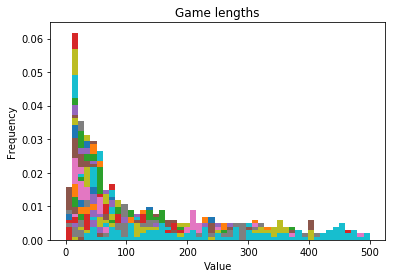

In [5]:
bins = np.linspace(0, 500, 50)
for score in game_lengths:
    plt.hist(score, bins, density=1)
plt.title("Game lengths")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show

In [17]:
for x in game_lengths:
    sns.distplot(x, hist=False, rug=False, kde_kws={"bw" : 5});

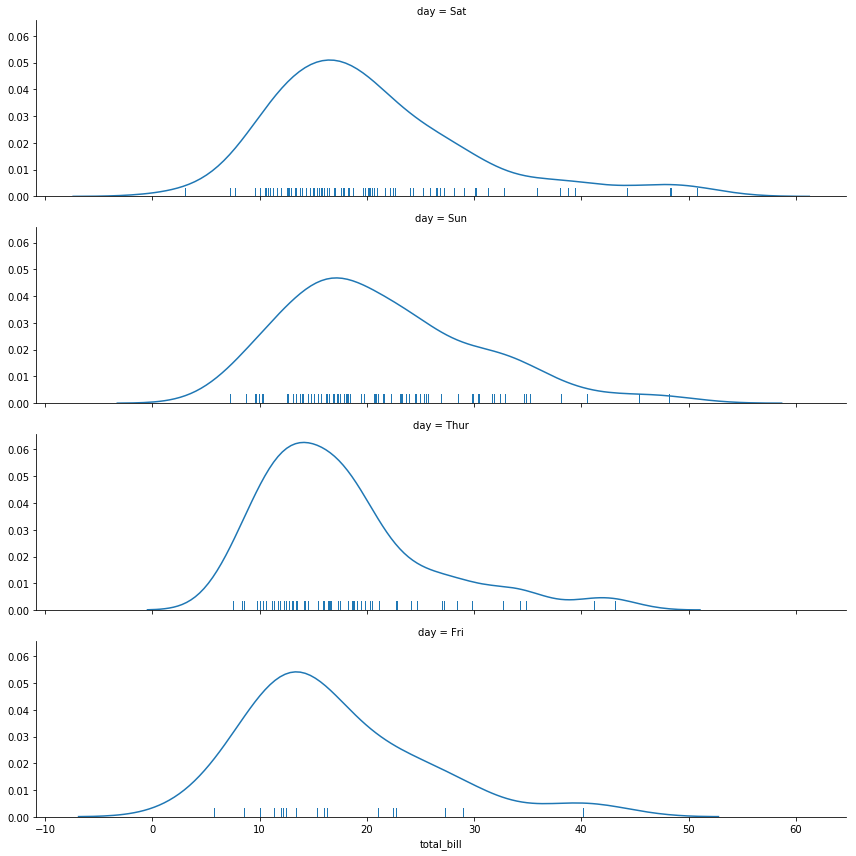

In [24]:
tips = sns.load_dataset("tips")
ordered_days = tips.day.value_counts().index
g = sns.FacetGrid(tips, row="day", row_order=ordered_days, aspect=4)
g.map(sns.distplot, "total_bill", hist=False, rug=True);

In [25]:
game_lengths

[array([10., 14., 18., 20., 11., 24., 21., 25., 29.,  9., 20., 17., 14.,
        16., 24., 10., 19., 31., 11., 23., 29., 10., 12., 12., 13., 11.,
        17., 24., 26., 15., 20., 46., 10., 11., 13., 45., 21., 13., 22.,
        11.,  8., 22., 17., 22., 48., 12., 20., 10., 10., 12., 12., 11.,
        11., 17., 20., 12., 12., 18., 35., 12., 14., 15., 10., 17., 25.,
        18., 29., 18., 12., 12., 16., 18., 12., 20., 19., 21., 12., 17.,
        10., 19., 17., 16., 15., 18.,  8., 23., 24., 21., 10., 11., 10.,
        12., 17., 23., 23., 37., 14., 16., 10., 27.]),
 array([21., 34., 20., 41., 12., 17., 12., 16., 13., 13., 17., 16.,  9.,
        11., 16., 23.,  9., 16.,  8.,  9., 10., 13.,  9., 18., 34., 25.,
        10.,  8., 22., 20., 19., 22., 22., 10., 21., 23., 21., 13., 24.,
        29., 18., 14., 10., 29., 16., 12., 36., 25., 14., 21., 11., 25.,
        20., 16., 14., 12., 28., 56., 15.,  9., 18., 16., 10., 16.,  9.,
        14.,  9., 21., 15., 12., 12., 14., 19., 26., 14., 14., 13., 1

In [31]:
labels = []
for i in range(np.array(game_lengths).shape[0]):
    labels.append(i*np.ones_like(game_lengths[i]))
labels = np.concatenate(labels)
x = np.concatenate(game_lengths)

In [36]:
df = pd.DataFrame(dict(game_length = x, turn=labels))
df

game_length  turn
0            10.0   0.0
1            14.0   0.0
2            18.0   0.0
3            20.0   0.0
4            11.0   0.0
5            24.0   0.0
6            21.0   0.0
7            25.0   0.0
8            29.0   0.0
9             9.0   0.0
10           20.0   0.0
11           17.0   0.0
12           14.0   0.0
13           16.0   0.0
14           24.0   0.0
15           10.0   0.0
16           19.0   0.0
17           31.0   0.0
18           11.0   0.0
19           23.0   0.0
20           29.0   0.0
21           10.0   0.0
22           12.0   0.0
23           12.0   0.0
24           13.0   0.0
25           11.0   0.0
26           17.0   0.0
27           24.0   0.0
28           26.0   0.0
29           15.0   0.0
...           ...   ...
9970        440.0  99.0
9971        460.0  99.0
9972        230.0  99.0
9973        201.0  99.0
9974        348.0  99.0
9975        111.0  99.0
9976        129.0  99.0
9977        391.0  99.0
9978        414.0  99.0
9979        160.0  99.0
9980        284.0  99.0
9981        495.0  99.0
9982        452.0  99.0
9983         59.0  99.0
9984        162.0  99.0
9985        425.0  99.0
9986        251.0  99.0
9987        430.0  99.0
9988        476.0  99.0
9989        304.0  99.0
9990        491.0  99.0
9991        450.0  99.0
9992         93.0  99.0
9993        311.0  99.0
9994        300.0  99.0
9995        262.0  99.0
9996        172.0  99.0
9997        147.0  99.0
9998        133.0  99.0
9999        435.0  99.0

[10000 rows x 2 columns]

In [40]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="turn", hue="turn", aspect=15, palette=pal)
g.map(sns.kdeplot, "game_length", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "game_length", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.fig.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)